In [ ]:
import os
import sys
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
from skimage.restoration import denoise_tv_chambolle
import scipy
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
MAX_DENSITY_NB = 25
EXT_WIDTH = 100
WIN_WIDTHS = np.arange(20, 100, 2)

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

In [ ]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [ ]:
def radius_list(xs:np.ndarray, ys:np.ndarray):
    assert xs.ndim == 1 and ys.ndim == 1
    rad_list = [0.]
    disp_list = []
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
        disp_list.append(np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2))
    return np.array(rad_list) / np.mean(disp_list) / len(xs)

In [ ]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(win_width//2, len(x_pos) - win_width//2):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[1: int(len(xs)/2)+1] - float(xs[1: int(len(xs)/2)+1][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
            ys1 = ys[1: int(len(ys)/2)+1] - float(ys[1: int(len(ys)/2)+1][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])        

            cum_xs1 = abs(np.cumsum(abs(xs1)))
            cum_xs2 = abs(np.cumsum(abs(xs2)))
            cum_ys1 = abs(np.cumsum(abs(ys1)))
            cum_ys2 = abs(np.cumsum(abs(ys2)))

            xs_max_val = max(np.max(abs(cum_xs1)), np.max(abs(cum_xs2)))
            cum_xs1 = cum_xs1 / xs_max_val
            cum_xs2 = cum_xs2 / xs_max_val

            ys_max_val = max(np.max(abs(cum_ys1)), np.max(abs(cum_ys2)))
            cum_ys1 = cum_ys1 / ys_max_val
            cum_ys2 = cum_ys2 / ys_max_val
            
            vals.append((abs(cum_xs1[-1] - cum_xs2[-1] + cum_ys1[-1] - cum_ys2[-1]))
                        + (max(np.std(xs1), np.std(xs2)) - min(np.std(xs1), np.std(xs2)))
                        + (max(np.std(ys1), np.std(ys2)) - min(np.std(ys1), np.std(ys2))))
                    
        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)

    all_vals = np.array(all_vals) + 1e-5
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [ ]:
def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [ ]:
def climb_mountain(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0<=x<signal.shape[0] else -1 for x in range(cp-seuil,cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp

In [ ]:
def position_extension(x, y, ext_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])[1:]
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])[1:]
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)
    return np.array(datas), delta_prev_data.shape[0], delta_next_data.shape[0]

In [ ]:
def sigmoid(x, beta=3):
    x = np.minimum(np.ones_like(x)*0.999, x)
    x = np.maximum(np.ones_like(x)*0.001, x)
    return 1 / (1 + (x / (1-x))**(-beta))

In [ ]:
def density_estimation(x, y, ext1, ext2, max_nb):
    densities = []
    dist_amp = 2.0
    local_mean_window_size = 5
    
    for i in range(x.shape[0]):
        density1 = 0
        density2 = 0
        
        slice_x = x[max(0, i-max_nb//2):i].copy()
        slice_y = y[max(0, i-max_nb//2):i].copy()
        
        if len(slice_x) > 0:
            mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x)//2]
            slice_y -= slice_y[len(slice_y)//2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                    density1 += 1
    
        slice_x = x[i:min(x.shape[0], i+max_nb//2)].copy()
        slice_y = y[i:min(x.shape[0], i+max_nb//2)].copy()
                
        if len(slice_x) > 0:
            mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x)//2]
            slice_y -= slice_y[len(slice_y)//2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                    density2 += 1
        densities.append(max(density1, density2))
        
    
    # local_mean
    new_densities = []
    for i in range(len(densities)):
        new_densities.append(np.mean(densities[max(0, i-local_mean_window_size//2): 
                                               min(len(densities), i+local_mean_window_size//2+1)]))
    densities = new_densities
        
    return np.array(densities)

In [ ]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    assert ext_width > shift_width
    datas, shape_ext1, shape_ext2 = position_extension(x, y, ext_width)
    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)

    density = density_estimation(datas[0], datas[1], 
                                 shape_ext1, shape_ext2, 
                                 max_nb=MAX_DENSITY_NB*2)

    denoised_den = denoise_tv_chambolle(density, weight=3, eps=0.0002, max_num_iter=100, channel_axis=None)
    denoised_den = sigmoid(denoised_den / MAX_DENSITY_NB)
    #denoised_den = 1
    
    signal = signal[:,] * denoised_den
    sliced_signals, slice_indice = slice_data(signal, jump_d, shape_ext1, shift_width)
    
    return (signal[:, shape_ext1:signal.shape[1] - shape_ext2],
            sliced_signals,
            slice_indice,
            signal,
            denoised_den,
            shape_ext1, shape_ext2)

In [ ]:
def local_roughness(signal, window_size):
    uc_signal = uncumulate(signal)
    uc_signal /= abs(uc_signal)
    counts = []
    for i in range(window_size//2, len(uc_signal) - window_size//2):
        count = 0
        cur_state = 1
        for j in range(i-window_size//2, i+window_size//2):
            new_state = uc_signal[j]
            if new_state != cur_state:
                count += 1
            cur_state = new_state
        counts.append(count)
    counts = np.concatenate(([counts[0]] * (window_size//2), counts))
    counts = np.concatenate((counts, [counts[-1]] * (window_size//2)))
    return counts

In [ ]:
def slice_normalize(slices):
    val = np.mean(np.sum(slices, axis=(2)).T, axis=0)
    val = val - np.min(val)
    val = val / np.max(val)
    return val

In [ ]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
track = 2
exp = 5
fovs = [0]
traj_idx = [0] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check,, exp10,fov0,idx7 check
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
changepoints = []

In [ ]:
trajs_model, labels_model = models_phenom().single_state(N=2,
                                                        L=None,
                                                        T=500,
                                                        alphas=1.5,
                                                        Ds=0.1,
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

In [ ]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=None,
                                                        T=500,
                                                        alphas=[0.5, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

In [ ]:
print(f'GT: {changepoints}, Length:{x.shape[0]}')
checkpoints = [0]

signals, sliced_signals, _, _, denoised_density, l_ext,_ = signal_from_extended_data(x, y,
                                                                            WIN_WIDTHS,
                                                                            EXT_WIDTH,
                                                                            1,
                                                                            10)
slice_norm_signal = slice_normalize(sliced_signals)
print(f'sig_mean: {np.mean(slice_norm_signal)}')

plt.figure(figsize=(10, 6))
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i] / np.max(signals[i]), alpha=0.1,
             c=color_seq[int(i * 255 / signals.shape[0])])
plt.plot(np.arange(signals.shape[1]), slice_norm_signal, c='red')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.ylim([0, 1])

if not isinstance(denoised_density, int):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(signals.shape[1]), denoised_density[l_ext:l_ext + signals.shape[1]], c='brown')
    for cp in changepoints:
        plt.vlines(cp, 0, 1, color='blue')
    plt.ylim([0, 1])

#############################################################################

plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for checkpoint in checkpoints:
    plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.set_ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for checkpoint in checkpoints:
    ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

In [ ]:
def signal_comparison(x_pos, y_pos, win_widths, ext_width, checkpoint1, checkpoint2, *args):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        xs1 = x_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        ys1 = y_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        
        xs2 = x_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        ys2 = y_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        
        xs1_l = xs1[1: int(len(xs1)/2)+1] - float(xs1[1: int(len(xs1)/2)+1][0])
        xs1_r = xs1[int(len(xs1)/2):] - float(xs1[int(len(xs1)/2):][0])

        ys1_l = ys1[1: int(len(ys1)/2)+1] - float(ys1[1: int(len(ys1)/2)+1][0])
        ys1_r = ys1[int(len(ys1)/2):] - float(ys1[int(len(ys1)/2):][0])
        
        xs2_l = xs2[1: int(len(xs2)/2)+1] - float(xs2[1: int(len(xs2)/2)+1][0])
        xs2_r = xs2[int(len(xs2)/2):] - float(xs2[int(len(xs2)/2):][0])

        ys2_l = ys2[1: int(len(ys2)/2)+1] - float(ys2[1: int(len(ys2)/2)+1][0])
        ys2_r = ys2[int(len(ys2)/2):] - float(ys2[int(len(ys2)/2):][0])
        
        std_xs1_l = np.std(xs1_l)
        std_xs1_r = np.std(xs1_r)
        std_ys1_l = np.std(ys1_l)
        std_ys1_r = np.std(ys1_r)
        std_xs2_l = np.std(xs2_l)
        std_xs2_r = np.std(xs2_r)
        std_ys2_l = np.std(ys2_l)
        std_ys2_r = np.std(ys2_r)
        
        xs1_l = np.cumsum(abs(xs1_l))
        xs1_r = np.cumsum(abs(xs1_r))
        ys1_l = np.cumsum(abs(ys1_l))
        ys1_r = np.cumsum(abs(ys1_r))
        xs2_l = np.cumsum(abs(xs2_l))
        xs2_r = np.cumsum(abs(xs2_r))
        ys2_l = np.cumsum(abs(ys2_l))
        ys2_r = np.cumsum(abs(ys2_r))

        #xs1_l, xs1_r, ys1_l, ys1_r
        #xs2_l, xs2_r, ys2_l, ys2_r
        comb = [[[xs1_l, xs2_r], [ys1_l, ys2_r]], [[xs1_r, xs2_r], [ys1_r, ys2_r]],
               [[xs1_l, xs2_l], [ys1_l, ys2_l]], [[xs1_r, xs2_l], [ys1_r, ys2_l]]]
        comb2 = [[std_xs1_l, std_xs2_r, std_ys1_l, std_ys2_r], [std_xs1_r, std_xs2_r, std_ys1_r, std_ys2_r],
                 [std_xs1_l, std_xs2_l, std_ys1_l, std_ys2_l], [std_xs1_r, std_xs2_l, std_ys1_r, std_ys2_l]]
                 
        for cb, cb2 in zip(comb, comb2):
            tmp_vals = []
            for s in cb:
                l, r = s[0], s[1]
                max_val = max(np.max(abs(l)), np.max(abs(r)))
                l_val = l / max_val
                r_val = r / max_val
                tmp_vals.append(l_val)
                tmp_vals.append(r_val)
            val = abs(tmp_vals[0][-1] - tmp_vals[1][-1] + tmp_vals[2][-1] - tmp_vals[3][-1])
                       #+ (max(cb2[0], cb2[1]) - min(cb2[0], cb2[1]))
                       #+ (max(cb2[2], cb2[3]) - min(cb2[2], cb2[3])))
            vals.append(val)
        vals = np.array(vals)
        all_vals.append(vals)
    all_vals = np.array(all_vals)
    mean_vals = np.sort(all_vals.T, axis=1)[:, int(len(win_widths) * 0.25): int(len(win_widths) * 0.75)].mean(axis=1)
    
    if checkpoint1 in args:
        print(checkpoint1, checkpoint2, mean_vals, win_widths[np.argmax(all_vals, axis=0)[0]])
        print(all_vals)
        
    if (mean_vals[1] + mean_vals[2]) / 2 >= 1 and (mean_vals[0] + mean_vals[3]) / 2 < 1 and mean_vals[1] > 1 and mean_vals[2] > 1:
        return 1
    elif (mean_vals[1] + mean_vals[2]) / 2 < 1. and (mean_vals[0] + mean_vals[3]) / 2 >= 1 and mean_vals[0] > 1 and mean_vals[3] > 1:
        return -1
    else:
        return 0

In [ ]:
def check_pts_mat(checkpoints, x, y, win_widths, ext_width, *args):
    cp_mat = np.zeros((len(checkpoints), len(checkpoints))).astype(int) - 1
    datas, k, kk = position_extension(x, y, ext_width)
    print(k, kk, ext_width)
    for i in range(cp_mat.shape[0]):
        for j in range(cp_mat.shape[1]):
            gap = abs(checkpoints[i] - checkpoints[j]) * 2
            gap = min(gap, 100)
            if i == j:
                gap = 80
            local_win_widths = np.arange(max(10, gap-20), gap+20, 2)
            cp_mat[i][j] = signal_comparison(datas[0], datas[1],
                                             local_win_widths, k,
                                             checkpoints[i], checkpoints[j], args)
    
    return cp_mat

In [ ]:
print(f'GT: {changepoints}')

xa = []
for det_cp in np.where(slice_norm_signal > 0.25)[0]:
    xa.append(climb_mountain(slice_norm_signal, det_cp, seuil=5))
xa = np.unique(xa)

print(xa)
print(xa[np.argsort(slice_norm_signal[xa])[::-1]])
check_arange = np.arange(50, 100, 2) #WIN_WIDTHS

In [ ]:
cor_mat = check_pts_mat(xa, x, y,
                        check_arange, EXT_WIDTH, [56])
print(cor_mat)
plt.figure(figsize = (11,8))
sns.heatmap(cor_mat, xticklabels=xa, yticklabels=xa)
plt.show()

In [ ]:
def model_selection(length):
    reg_model_num = -1
    seuil = -1
    if length < 8:
        reg_model_num = 5
        seuil = 0.60
        
    elif length < 12:
        reg_model_num = 8
        seuil = 0.50

    elif length < 16:
        reg_model_num = 12
        seuil = 0.35

    elif length < 32:
        reg_model_num = 16
        seuil = 0.30

    elif length < 48:
        reg_model_num = 32
        seuil = 0.25

    elif length < 64:
        reg_model_num = 48
        seuil = 0.20

    elif length < 128:
        reg_model_num = 64
        seuil = 0.15

    elif length < 144:
        reg_model_num = 128
        seuil = 0.10

    else:
        reg_model_num = 144
        seuil = 0.10

    return reg_model_num, seuil

In [ ]:
def cvt_2_signal(x, y):
    rad_list = radius_list(x, y)
    x = x / (np.std(x))
    x = np.cumsum(abs(uncumulate(x))) / len(x)
    y = y / (np.std(y))
    y = np.cumsum(abs(uncumulate(y))) / len(y)
    return np.vstack((x, rad_list)).T, np.vstack((y, rad_list)).T

In [ ]:
def partition_trajectory(x, y, cps):
    if len(cps) == 0:
        return [x], [y]
    new_x = []
    new_y = []
    for i in range(1, len(cps)):
        new_x.append(x[cps[i-1]:cps[i]].copy())
        new_y.append(y[cps[i-1]:cps[i]].copy())
    return new_x, new_y

In [ ]:
reg_model_nums = [5, 8, 12, 16, 32, 48, 64, 128, 144]
reg_models = {n:tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{n}.keras') for n in reg_model_nums}

### TEST

In [ ]:
def sort_by_signal(signal, cps):
    sort_indice = np.argsort(signal[cps])
    indice_tuple = [(i, i+1) for i in sort_indice]
    return indice_tuple, sort_indice

In [ ]:
def recoupe_trajectory(x, y, model_num, jump=1):
    couped_x = []
    couped_y = []
    for i in range(0, len(x), jump):
        tmp1 = x[i: i+model_num]
        tmp2 = y[i: i+model_num]
        if len(tmp1) == model_num:
            couped_x.append(tmp1)
            couped_y.append(tmp2)
    return np.array(couped_x), np.array(couped_y)

In [27]:
def exhaustive_cps_search(x, y, win_widths, ext_width, search_seuil=0.20, cluster=None):
    if len(x) < np.min(reg_model_nums):
        return np.array([0, len(x)]), np.array([1.0]), np.array([0.1]), np.array([len(x)])
    
    if cluster is not None and len(cluster.means_) == 1:
        start_cps = []
        slice_norm_signal = np.zeros_like(x.shape)
    else:
        if len(x) + 2*(len(x)-1) >= win_widths[0]:
            signals, sliced_signals, _, _, denoised_density, l_ext,_ = signal_from_extended_data(x, y,
                                                                                        win_widths,
                                                                                        ext_width,
                                                                                        1,
                                                                                        10)
            slice_norm_signal = slice_normalize(sliced_signals)

            det_cps = []
            for det_cp in np.where(slice_norm_signal > search_seuil)[0]:
                det_cps.append(climb_mountain(slice_norm_signal, det_cp, seuil=5))
            det_cps = np.unique(det_cps)
            start_cps = list(det_cps.copy())
        else:
            start_cps = []
            slice_norm_signal = np.zeros_like(x.shape)

    start_cps.append(0)
    start_cps.append(len(x))
    start_cps = np.sort(start_cps)
    cps_copy = [0]
    for i in range(1, len(start_cps)-1):
        if start_cps[i] - start_cps[i-1] > 5 and start_cps[i+1] - start_cps[i] > 5:
            cps_copy.append(start_cps[i])
    start_cps = cps_copy
    start_cps.append(len(x))
    #print('First cps: ',start_cps)
    
    while True:
        filtered_cps = []
        alpha_preds = []
        seuil_preds = []
        k_preds = []
        
        part_xs, part_ys = partition_trajectory(x, y, start_cps)
        for p_x, p_y in zip(part_xs, part_ys):
            input_signals = []
            disp = []
            
            model_num, seuil = model_selection(len(p_x))
            #model_num, seuil = 16, 0.2
            model = reg_models[model_num]
            #print(p_x.shape, model_num)
            re_couped_x, re_couped_y = recoupe_trajectory(p_x, p_y, model_num)
            for r_x, r_y in zip(re_couped_x, re_couped_y):
                input_signal1, input_signal2 = cvt_2_signal(r_x, r_y)
                input_signals.append(input_signal1)
                input_signals.append(input_signal2)

            input_signals = np.array(input_signals).reshape(-1, model_num, 1, 2)
            pred_alpha = model.predict(input_signals, verbose=0).flatten()
            #print(pred_alpha)
            if len(pred_alpha) > 4:
                pred_alpha = np.sort(pred_alpha)[int(0.25 * len(pred_alpha)): int(0.75 * len(pred_alpha))].mean()
            else:
                pred_alpha = np.mean(pred_alpha)
            
            for j in range(1, len(p_x)):
                x_seg = p_x[j] - p_x[j-1]
                y_seg = p_y[j] - p_y[j-1]
                disp.append(np.sqrt(x_seg**2 + y_seg**2) / 4.)
                
            k_preds.append(np.mean(disp))
            alpha_preds.append(pred_alpha)
            seuil_preds.append(seuil)
            
        delete_cps = -1
        if cluster is not None:
            sorted_indice_tuple, sorted_indice = sort_by_signal(slice_norm_signal, start_cps[1:-1])
            for (l, r), i in zip(sorted_indice_tuple, sorted_indice):
                i += 1
                diff_alpha = abs(alpha_preds[l] - alpha_preds[r])
                diff_seuil = (seuil_preds[l] + seuil_preds[r])

                cluster_pred = cluster.predict([[alpha_preds[l], k_preds[l]], [alpha_preds[r], k_preds[r]]])
                #print(alpha_preds)
                #print(start_cps, cluster_pred)
                if cluster_pred[0] == cluster_pred[1]:
                    delete_cps = start_cps[i]
                    
                    """
                    print(cluster_pred)
                    print('------------------------')
                    
                    print('entered:', start_cps)
                    print(alpha_preds[l], alpha_preds[r])
                    print(prior_alpha.pdf(alpha_preds[l]), prior_alpha.pdf(alpha_preds[r]))
                    print('------------------------')
                    p_mean = np.sum(prior_alpha.pdf(alpha_preds[l]) + prior_alpha.pdf(alpha_preds[r]))/2.
                    from_cp = start_cps[i-1]
                    if i+1 > len(start_cps)-1:
                        to_cp = len(x)
                    else:
                        to_cp = start_cps[i+1]
                    input_signals = []
                    model_num, seuil = model_selection(to_cp - from_cp)
                    model = reg_models[model_num]

                    re_couped_x, re_couped_y = recoupe_trajectory(x[from_cp:to_cp], y[from_cp:to_cp], model_num)
                    for r_x, r_y in zip(re_couped_x, re_couped_y):
                        input_signal1, input_signal2 = cvt_2_signal(r_x, r_y)
                        input_signals.append(input_signal1)
                        input_signals.append(input_signal2)

                    input_signals = np.array(input_signals).reshape(-1, model_num, 1, 2)
                    pred_alpha = model.predict(input_signals, verbose=0).flatten()
                    pred_alpha = np.mean(pred_alpha)
                    p_merged = prior_alpha.pdf(pred_alpha)
                    print('merged_alpha:',pred_alpha, ' --- pmerged:',p_merged, ' ---- pmean:',p_mean)
                    if p_merged >= p_mean:
                        delete_cps = start_cps[i]
                        break
                    """

        if delete_cps == -1:
            filtered_cps = start_cps
            break
        else:
            start_cps.remove(delete_cps)
            

            
    """
    if cluster is not None:
        adjusted_alphas = []
        non_sup_preds = cluster.predict(np.vstack((np.zeros_like(alpha_preds), alpha_preds)).T)
        cluster.means_[:,1]
        for nsp in non_sup_preds:
            adjusted_alphas.append(cluster.means_[:,1][nsp])
        alpha_preds = adjusted_alphas
    """

    seg_lengths = uncumulate(np.array(filtered_cps))[1:]
    
    alpha_preds = np.array(alpha_preds)
    filtered_cps = np.array(filtered_cps)
    k_preds = np.array(k_preds)
    return filtered_cps, alpha_preds, k_preds, seg_lengths

In [ ]:
print(f'GT: {changepoints}')
detected_points = exhaustive_cps_search(x, y, WIN_WIDTHS, EXT_WIDTH, 0.25)
print(detected_points)

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for dtp in detected_points[0][1:-1]:
    plt.scatter(x[dtp], y[dtp], marker='+', c='green')
plt.xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.set_ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for dtp in detected_points[0]:
    ax.scatter3D(x[dtp], y[dtp], np.arange(signals.shape[1])[dtp], marker='+', c='green')

# Produce results

In [ ]:
def gauss2d(x, mu_x, mu_y, sigma_x, sigma_y, norm_factor):
    return norm_factor * np.exp(-1/2 * (((x[0] - mu_x)/sigma_x)**2 + ((x[1] - mu_y)/sigma_y)**2))

In [ ]:
def gauss1d(x, mu, fixed_sigma, norm_fac):
    #fixed_sigma = 1.0
    return norm_fac * np.exp((-1/2) * ((x - mu) / fixed_sigma) ** 2)

In [ ]:
public_data_path = f'public_data_validation_v1/' # make sure the folder has this name or change it
submit_number = 1
path_results = f'result_validation_{submit_number}/'
if not os.path.exists(path_results):
    os.makedirs(path_results)

N_EXP = 13
N_FOVS = 30

In [ ]:
for track in [1,2]:
    
    # Create the folder of the track if it does not exists
    path_track = path_results + f'track_{track}/'
    if not os.path.exists(path_track):
        os.makedirs(path_track)
        
    for exp in range(N_EXP):
        # Create the folder of the experiment if it does not exits
        path_exp = path_track+f'exp_{exp}/'
        if not os.path.exists(path_exp):
            os.makedirs(path_exp)
        """
        file_name = path_exp + 'ensemble_labels.txt'
        
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states (2 in this case)
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {2} \n')

            # Create some dummy data for 2 states. This means 2 columns
            # and 5 rows
            data = np.random.rand(5, 2)
            
            data[-1,:] /= data[-1,:].sum()

            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')
        """

In [ ]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [0]:
    path_track = path_results + f'track_{track}/'

    for exp in range(N_EXP):
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks']
            no_priors = False
        except:
            no_priors = True

        if no_priors:
            all_seg_lengths = []
            all_alphas = []
            all_ks = []
            
            for fov in range(N_FOVS):
                # We read the corresponding csv file from the public data and extract the indices of the trajectories:
                if track == 2:
                    df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
                else:
                    df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
                traj_idx = np.sort(df.traj_idx.unique())

                # Loop over each index
                for idx in traj_idx:
                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]
                
                    cps, alphas, ks, seg_lengths = exhaustive_cps_search(x, y,
                                                                         WIN_WIDTHS,
                                                                         EXT_WIDTH,
                                                                         search_seuil=0.40)
                    all_alphas.extend(alphas)
                    all_seg_lengths.extend(seg_lengths)
                    all_ks.extend(ks)

            all_alphas = np.array(all_alphas)
            all_seg_lengths = np.array(all_seg_lengths)
            all_ks = np.array(all_ks)
            np.savez(f'{path_results}/priors_{track}_{exp}.npz', alphas=all_alphas, seg_lengths=all_seg_lengths, all_ks=all_ks)

In [ ]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [2]:
    path_track = path_results + f'track_{track}/'

    for exp in range(N_EXP):
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            #loaded = np.load(f'{path_results}/old_priors_0.20_seuil/old_priors_{track}_{exp}.npz')
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks']
            no_priors = False
        except:
            no_priors = True
            print(f'No priors for exp:{exp}')
            
        print('--- post processing ---')
        sampling_nb = 1000
        alpha_range = np.linspace(-0.2, 2.2, 100)
        k_range = np.linspace(-0.2, np.max(all_ks), 100)
        all_alphas = all_alphas[np.argwhere((all_seg_lengths > 32) & (all_seg_lengths < 256)).flatten()]
        all_ks = all_ks[np.argwhere((all_seg_lengths > 32) & (all_seg_lengths < 256)).flatten()]

        H, xedges, yedges = np.histogram2d(all_alphas, all_ks, bins=[alpha_range, k_range])
        H = H / np.sum(H)


        poten_nb_states = 0
        for data, data_range in zip([all_alphas, all_ks], [alpha_range, k_range]):
            nb_states = 0
            weight_sum = 0
            
            hist = np.histogram(data, bins=data_range)
            prior_info = scipy.stats.rv_histogram(hist, density=True)
            p_ = prior_info.pdf(data_range)
            p_ = p_ / np.sum(p_)
            samples = np.random.choice(data_range, p=p_, size=5000)
            samples = np.vstack((np.zeros_like(samples), samples)).T
            bgm = BayesianGaussianMixture(n_components=4, max_iter=2000, n_init=10).fit(samples)
            
            for mean, weight in zip(bgm.means_[np.argsort(bgm.weights_)[::-1]],
                                    bgm.weights_[np.argsort(bgm.weights_)[::-1]]):
                weight_sum += weight
                nb_states += 1
                if weight_sum >= 0.90:
                    break
            poten_nb_states = max(poten_nb_states, nb_states)
            print(bgm.weights_)
            print(f'nb_state:{nb_states}')
            
        print(f'Estimated nb clusters: {poten_nb_states}')
        cluster = GaussianMixture(n_components=poten_nb_states, max_iter=1000, n_init=10,
                                          covariance_type='diag').fit(np.vstack((all_alphas, all_ks)).T)
        print('Cluster centers: ', cluster.means_)
        print(cluster.weights_)
        print(cluster.n_features_in_)

        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = np.sort(df.traj_idx.unique())
            submission_file = path_exp + f'fov_{fov}.txt'
            with open(submission_file, 'w') as f:
                # Loop over each index
                for idx in traj_idx:
                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]

                    cps, alphas, ks, _ = exhaustive_cps_search(x, y, WIN_WIDTHS,
                                                               EXT_WIDTH,
                                                               search_seuil=0.25,
                                                               cluster=cluster)

                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip(ks, alphas, [99999999] * len(cps), cps[1:]):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')


Submit number: 1
Track: 2, Exp: 0
--- post processing ---
[0.68017272 0.15797505 0.14308028 0.01877195]
nb_state:3
[5.04806614e-01 1.69590252e-01 3.25560484e-01 4.26494911e-05]
nb_state:3
Estimated nb clusters: 3
Cluster centers:  [[1.08184976 0.70667833]
 [0.07454391 0.4724718 ]
 [0.80358422 0.68366134]]
[0.47327758 0.16191771 0.36480472]
2


[0]
[1]
[2]
[3]


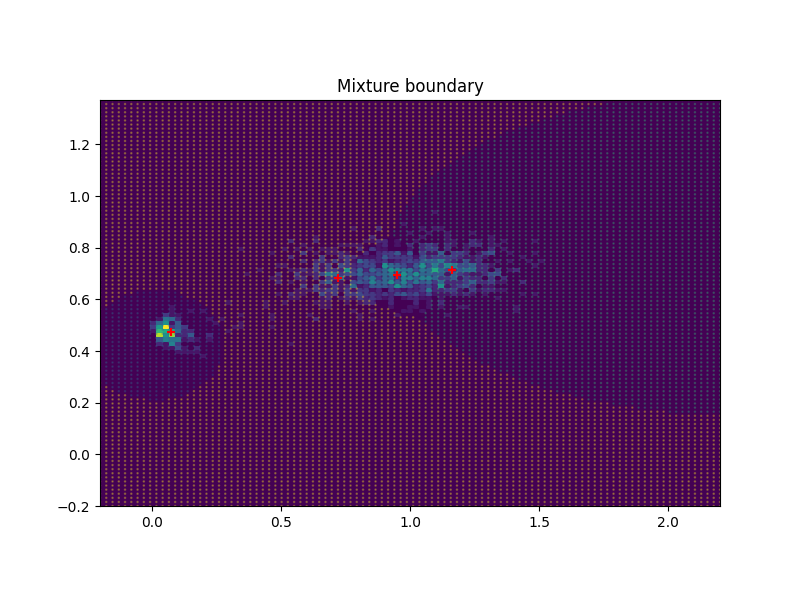

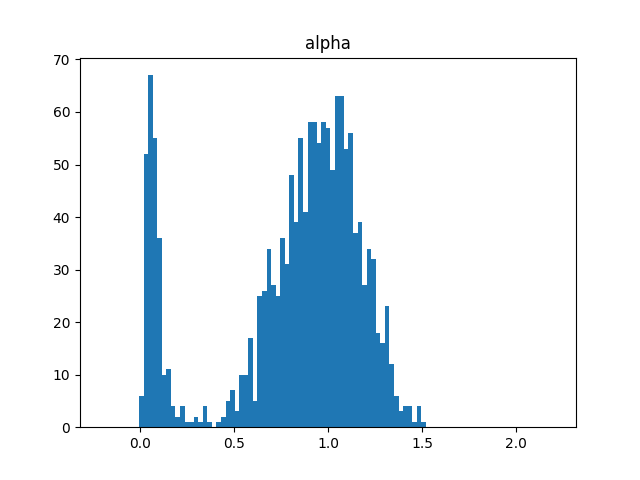

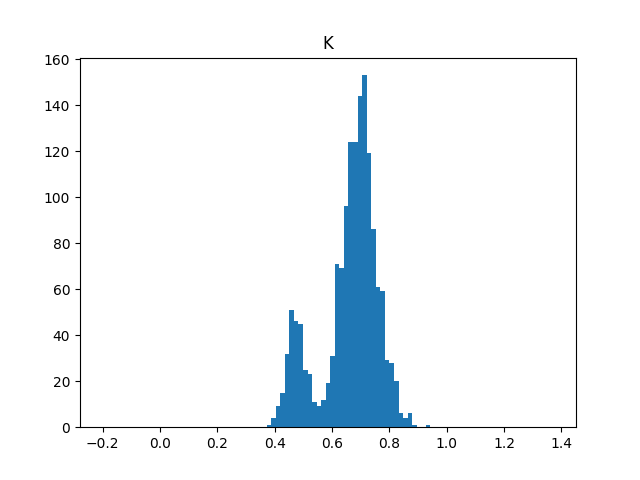

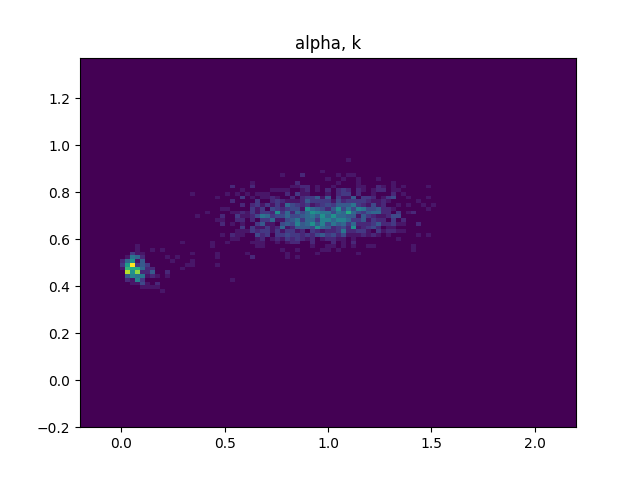

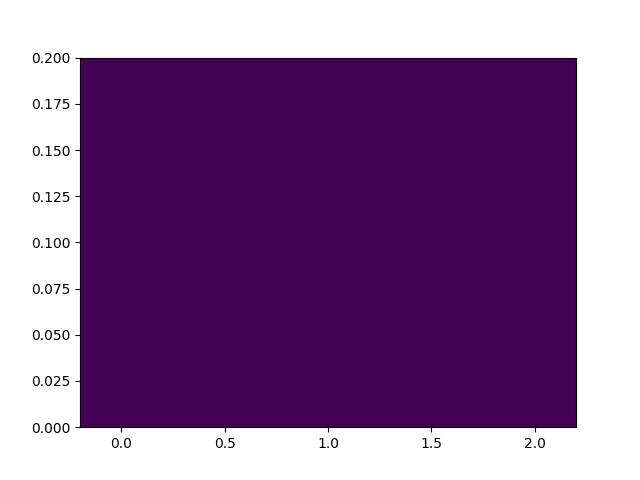

In [30]:
plt.figure()
plt.title('alpha')
plt.hist(all_alphas, bins=alpha_range)
plt.figure()
plt.title('K')
plt.hist(all_ks, bins=k_range)

plt.figure()
plt.title('alpha, k')
plt.hist2d(all_alphas, all_ks, bins=[xedges, yedges])
plt.figure()
plt.hist2d(all_alphas, all_ks, bins=[xedges, np.linspace(0.0, 0.2, 25)])

plt.figure(figsize=(8, 6))
plt.title("Mixture boundary")
ZX, ZY = np.meshgrid(alpha_range, k_range)
Z = np.stack((ZX, ZY)).T.reshape(-1, 2)
ZC = cluster.predict(Z)
plt.scatter(Z[:,0], Z[:,1], c=ZC, s=0.7, alpha=0.3, zorder=1)
plt.imshow(H.T, extent=(alpha_range[0], alpha_range[-1], k_range[0], k_range[-1]), origin='lower', alpha=1.0)
#plt.hist2d(all_alphas, all_ks, bins=[xedges, yedges])
for cluster_mean in cluster.means_:
    plt.scatter(cluster_mean[0], cluster_mean[1], marker='+', c='red')
    print(cluster.predict([[cluster_mean[0], cluster_mean[1]]]))
plt.show()

In [ ]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [2]:
    path_track = path_results + f'track_{track}/'

    for exp in [0]:
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            #loaded = np.load(f'{path_results}/old_priors_0.20_seuil/old_priors_{track}_{exp}.npz')
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks']
            no_priors = False
        except:
            no_priors = True
            print(f'No priors for exp:{exp}')
            
        print('--- post processing ---')
        sampling_nb = 1000
        alpha_range = np.linspace(-0.2, 2.2, 100)
        k_range = np.linspace(-0.2, np.max(all_ks), 100)
        all_alphas = all_alphas[np.argwhere((all_seg_lengths > 32) & (all_seg_lengths < 256)).flatten()]
        all_ks = all_ks[np.argwhere((all_seg_lengths > 32) & (all_seg_lengths < 256)).flatten()]
        print(all_alphas.shape)
        print(all_ks.shape)
        print(np.argwhere(all_seg_lengths > 64).shape)

        H, xedges, yedges = np.histogram2d(all_alphas, all_ks, bins=[alpha_range, k_range])
        H = H / np.sum(H)
        poten_nb_states = 1
        for data, data_range in zip([all_alphas, all_ks], [alpha_range, k_range]):
            hist = np.histogram(data, bins=data_range)
            prior_info = scipy.stats.rv_histogram(hist, density=True)
            p_ = prior_info.pdf(data_range)
            p_ = p_ / np.sum(p_)
            samples = np.random.choice(data_range, p=p_, size=3000)
            samples = np.vstack((np.zeros_like(samples), samples)).T
            bgm = BayesianGaussianMixture(n_components=4, max_iter=1000).fit(samples)
            popts = []
            pcovs = []
            for bgm_mean in bgm.means_[:, 1]:
                popt, pcov = scipy.optimize.curve_fit(gauss1d, data_range,
                                                      prior_info.pdf(data_range),
                                                      p0=[bgm_mean, 0.1, 1])
                if len(popts) == 0:
                    popts.append(popt)
                    pcovs.append(pcov)
                else:
                    flag = 1
                    for comp_popt in popts:
                        if not np.allclose(comp_popt, popt, rtol=1e-1):
                            flag *= 1
                        else:
                            flag *= 0
                    if flag == 1:
                        popts.append(popt)
                        pcovs.append(pcov)
            popts = np.array(popts)
            pcovs = np.array(pcovs)
            poten_nb_states = max(poten_nb_states, len(popts))
            print(len(popts))
            print(popts)
            print(bgm.n_features_in_)
            print(bgm.means_)
            print(bgm.weights_)
            
        print('Number of clusters: ', poten_nb_states)
        cluster = GaussianMixture(n_components=poten_nb_states, max_iter=10, n_init=10,
                                  covariance_type='diag').fit(np.vstack((all_alphas, all_ks)).T)
        
        print('Cluster centers: ', cluster.means_)

        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = np.sort(df.traj_idx.unique())
            submission_file = path_exp + f'fov_{fov}.txt'
            with open(submission_file, 'w') as f:
                # Loop over each index
                for idx in traj_idx:
                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]

                    cps, alphas, ks, _ = exhaustive_cps_search(x, y, WIN_WIDTHS,
                                                               EXT_WIDTH,
                                                               search_seuil=0.25,
                                                               cluster=cluster,
                                                               popts=popts)

                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip(ks, alphas, [99999999] * len(cps), cps[1:]):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')


In [ ]:
# Generate random independent variable
x = np.random.randn(300)

# Generate random noise for each dependent variable
noise = np.random.randn(300)

# Generate dependent variables based on the independent variable and noise
y = 2 * x + noise

In [ ]:
def p_x_given_y(x, y):
    # Specify the parameters of the conditional distribution
    # You can use any appropriate distribution based on your problem
    mean_x = np.mean(x)
    var_x = np.var(x)
    print(var_x)
    precision_x = 1 / var_x
    
    # Sample from the conditional distribution
    sampled_x = np.random.normal((np.mean(y) * precision_x) / (len(y) * precision_x + 1), np.sqrt(1 / (len(y) * precision_x + 1)))
    
    return sampled_x

# Conditional distribution of each dependent variable given the independent variable
def p_y_given_x(x, y):
    # Specify the parameters of the conditional distribution
    # You can use any appropriate distribution based on your problem
    mean_y = np.mean(y)
    var_y = np.var(y)
    print(var_y)
    precision_y = 1 / var_y
    
    # Sample from the conditional distribution for each dependent variable
    sampled_y = np.random.normal(mean_y + precision_y * (y - 2 * x), np.sqrt(1 / (len(y) * precision_y + 1)))
    
    return sampled_y

In [ ]:
# Initialize variables
num_iterations = 1000
samples_x = np.zeros(num_iterations)
samples_y = np.zeros((num_iterations, len(y)))

# Initialize starting values for x and y
current_x = np.random.randn()
current_y = np.random.randn(len(y))

# Perform Gibbs sampling
for i in range(num_iterations):
    # Sample x given y
    current_x = p_x_given_y(current_x, current_y)
    samples_x[i] = current_x
    
    # Sample y given x
    current_y = p_y_given_x(current_x, current_y)
    samples_y[i, :] = current_y

In [ ]:
# Print mean and standard deviation of the samples
print("Mean of x: ", np.mean(samples_x))
print("Standard deviation of x: ", np.std(samples_x))
print("Mean of y: ", np.mean(samples_y, axis=0))
print("Standard deviation of y: ", np.std(samples_y, axis=0))

# Plot the samples
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(samples_x)
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Gibbs Sampling - Independent Variable')

plt.subplot(2, 1, 2)
for i in range(len(y)):
    plt.plot(samples_y[:, i])
plt.xlabel('Iteration')
plt.ylabel('y')
plt.title('Gibbs Sampling - Dependent Variables')

plt.tight_layout()
plt.show()